In [24]:
from __future__ import print_function
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torchvision import utils

In [25]:
def imshow(inp, save=False, title=None):
    """Imshow for Tensor."""
    fig = plt.figure(figsize=(5, 5))
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp,cmap='gray')
    plt.show()

In [26]:
class MLP_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, ngpu):
        super(MLP_G, self).__init__()
        self.ngpu = ngpu

        main = nn.Sequential(
            # Z goes into a linear of size: ngf
            nn.Linear(nz, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, nc * isize * isize),
        )
        self.main = main
        self.nc = nc
        self.isize = isize
        self.nz = nz

    def forward(self, input):
        input = input.view(input.size(0), input.size(1))
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output.view(output.size(0), self.nc, self.isize, self.isize)

In [27]:
class MLP_D(nn.Module):
    def __init__(self, isize, nz, nc, ndf, ngpu):
        super(MLP_D, self).__init__()
        self.ngpu = ngpu

        main = nn.Sequential(
            # Z goes into a linear of size: ndf
            nn.Linear(nc * isize * isize, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, 1),
        )
        self.main = main
        self.nc = nc
        self.isize = isize
        self.nz = nz

    def forward(self, input):
        input = input.view(input.size(0),
                           input.size(1) * input.size(2) * input.size(3))
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        output = output.mean(0)
        return output.view(1)

In [28]:
class DCGAN_D(nn.Module):
    def __init__(self, isize, nz, nc, ndf, ngpu, n_extra_layers=0):
        super(DCGAN_D, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        main = nn.Sequential()
        # input is nc x isize x isize
        main.add_module('initial.conv.{0}-{1}'.format(nc, ndf),
                        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False))
        main.add_module('initial.relu.{0}'.format(ndf),
                        nn.LeakyReLU(0.2, inplace=True))
        csize, cndf = isize / 2, ndf

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}.{1}.conv'.format(t, cndf),
                            nn.Conv2d(cndf, cndf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}.{1}.batchnorm'.format(t, cndf),
                            nn.BatchNorm2d(cndf))
            main.add_module('extra-layers-{0}.{1}.relu'.format(t, cndf),
                            nn.LeakyReLU(0.2, inplace=True))

        while csize > 4:
            in_feat = cndf
            out_feat = cndf * 2
            main.add_module('pyramid.{0}-{1}.conv'.format(in_feat, out_feat),
                            nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False))
            main.add_module('pyramid.{0}.batchnorm'.format(out_feat),
                            nn.BatchNorm2d(out_feat))
            main.add_module('pyramid.{0}.relu'.format(out_feat),
                            nn.LeakyReLU(0.2, inplace=True))
            cndf = cndf * 2
            csize = csize / 2

        # state size. K x 4 x 4
        main.add_module('final.{0}-{1}.conv'.format(cndf, 1),
                        nn.Conv2d(cndf, 1, 4, 1, 0, bias=False))
        self.main = main


    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else: 
            output = self.main(input)
            
        output = output.mean(0)
        return output.view(1)

In [29]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, ngpu, n_extra_layers=0):
        super(DCGAN_G, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize != isize:
            cngf = cngf * 2
            tisize = tisize * 2

        main = nn.Sequential()
        # input is Z, going into a convolution
        main.add_module('initial.{0}-{1}.convt'.format(nz, cngf),
                        nn.ConvTranspose2d(nz, cngf, 4, 1, 0, bias=False))
        main.add_module('initial.{0}.batchnorm'.format(cngf),
                        nn.BatchNorm2d(cngf))
        main.add_module('initial.{0}.relu'.format(cngf),
                        nn.ReLU(True))

        csize, cndf = 4, cngf
        while csize < isize//2:
            main.add_module('pyramid.{0}-{1}.convt'.format(cngf, cngf//2),
                            nn.ConvTranspose2d(cngf, cngf//2, 4, 2, 1, bias=False))
            main.add_module('pyramid.{0}.batchnorm'.format(cngf//2),
                            nn.BatchNorm2d(cngf//2))
            main.add_module('pyramid.{0}.relu'.format(cngf//2),
                            nn.ReLU(True))
            cngf = cngf // 2
            csize = csize * 2

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}.{1}.conv'.format(t, cngf),
                            nn.Conv2d(cngf, cngf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}.{1}.batchnorm'.format(t, cngf),
                            nn.BatchNorm2d(cngf))
            main.add_module('extra-layers-{0}.{1}.relu'.format(t, cngf),
                            nn.ReLU(True))

        main.add_module('final.{0}-{1}.convt'.format(cngf, nc),
                        nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        main.add_module('final.{0}.tanh'.format(nc),
                        nn.Tanh())
        self.main = main

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else: 
            output = self.main(input)
        return output 

In [30]:
ngpu = 1 # number of GPUs to use
nz = 100 # size of the latent z vector
ngf = 512
ndf = 512
nc = 1 # input image channels
n_extra_layers = 0 # Number of extra layers on gen and disc

imageSize = 28
batchSize = 100
n_workers = 2


adam = False
lrD = 0.00005
lrG = 0.00005

beta1 = 0.5 # beta1 for adam. default=0.5
niter = 500 # number of epochs to train for
Diters = 5 #number of D iters per each G iter



clamp_lower = -0.01
clamp_upper = 0.01

experiment = './experiment' # Where to store samples and models
data_root = './data'

epsilon = 1 # panalty weight
L = 10 # sinkhorn iteration num

netG_path = ''
netD_path = ''

cuda = True

In [31]:
# get data
dataset = dset.MNIST(root=data_root, download=True,
                           transform=transforms.Compose([
                               transforms.Scale(imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                         shuffle=True, num_workers=n_workers)

In [32]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [33]:
netG = MLP_G(imageSize, nz, nc, ngf, ngpu)
netD = MLP_D(imageSize, nz, nc, ndf, ngpu)

netG.apply(weights_init)
if netG_path != '': # load checkpoint if needed
    netG.load_state_dict(torch.load(netG_path))
print(netG)

netD.apply(weights_init)
if netD_path != '':
    netD.load_state_dict(torch.load(netD_path))
print(netD)


MLP_G (
  (main): Sequential (
    (0): Linear (100 -> 512)
    (1): ReLU (inplace)
    (2): Linear (512 -> 512)
    (3): ReLU (inplace)
    (4): Linear (512 -> 512)
    (5): ReLU (inplace)
    (6): Linear (512 -> 784)
  )
)
MLP_D (
  (main): Sequential (
    (0): Linear (784 -> 512)
    (1): ReLU (inplace)
    (2): Linear (512 -> 512)
    (3): ReLU (inplace)
    (4): Linear (512 -> 512)
    (5): ReLU (inplace)
    (6): Linear (512 -> 1)
  )
)


In [34]:
input = torch.FloatTensor(batchSize, 3, imageSize, imageSize)
noise = torch.FloatTensor(batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
one = torch.FloatTensor([1])
mone = one * -1

In [35]:
if torch.cuda.is_available():
    netG.cuda()
    netD.cuda()
    input = input.cuda()
    one, mone = one.cuda(), mone.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

In [36]:
if adam:
    optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999))
else:
    optimizerD = optim.RMSprop(netD.parameters(), lr = lrD)
    optimizerG = optim.RMSprop(netG.parameters(), lr = lrG)

[8/500][200/600][50] Loss_D: -8.529057 Loss_G: -1.194492 Loss_D_real: -9.715437 Loss_D_fake -1.186380


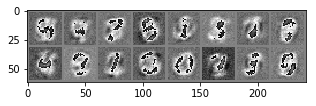

[16/500][400/600][100] Loss_D: -8.093824 Loss_G: -1.350659 Loss_D_real: -9.339026 Loss_D_fake -1.245202


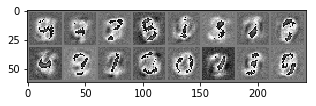

[24/500][600/600][150] Loss_D: -8.399227 Loss_G: -0.834356 Loss_D_real: -9.568272 Loss_D_fake -1.169044


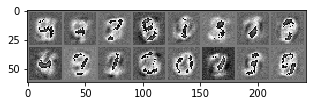

[33/500][200/600][200] Loss_D: -7.926799 Loss_G: -1.017610 Loss_D_real: -8.994742 Loss_D_fake -1.067943


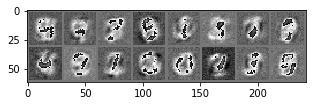

[41/500][400/600][250] Loss_D: -8.068405 Loss_G: -1.232386 Loss_D_real: -9.304122 Loss_D_fake -1.235717


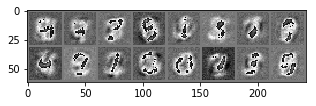

[49/500][600/600][300] Loss_D: -7.811864 Loss_G: -1.337097 Loss_D_real: -8.743401 Loss_D_fake -0.931537


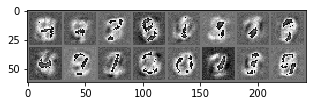

[58/500][200/600][350] Loss_D: -7.984487 Loss_G: -1.124690 Loss_D_real: -9.039424 Loss_D_fake -1.054937


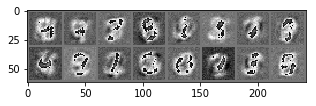

[66/500][400/600][400] Loss_D: -7.799761 Loss_G: -1.058985 Loss_D_real: -9.080883 Loss_D_fake -1.281122


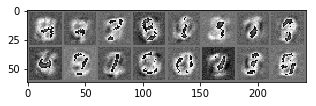

[74/500][600/600][450] Loss_D: -8.029306 Loss_G: -1.039644 Loss_D_real: -9.163094 Loss_D_fake -1.133787


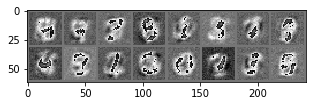

[83/500][200/600][500] Loss_D: -8.079606 Loss_G: -1.020645 Loss_D_real: -9.261288 Loss_D_fake -1.181682


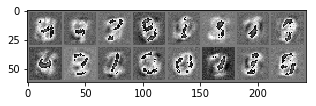

[91/500][400/600][550] Loss_D: -7.285251 Loss_G: -1.030488 Loss_D_real: -8.516459 Loss_D_fake -1.231208


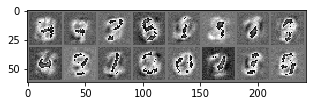

[99/500][600/600][600] Loss_D: -7.569328 Loss_G: -1.272001 Loss_D_real: -8.665185 Loss_D_fake -1.095857


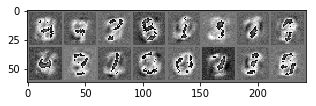

[108/500][200/600][650] Loss_D: -7.283538 Loss_G: -1.321998 Loss_D_real: -8.219971 Loss_D_fake -0.936432


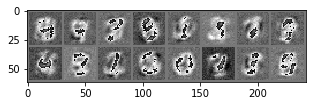

[116/500][400/600][700] Loss_D: -7.271131 Loss_G: -1.041705 Loss_D_real: -8.500629 Loss_D_fake -1.229499


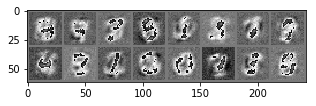

[124/500][600/600][750] Loss_D: -6.570677 Loss_G: -1.062409 Loss_D_real: -8.106951 Loss_D_fake -1.536273


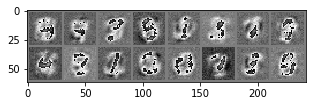

[133/500][200/600][800] Loss_D: -7.205245 Loss_G: -1.236143 Loss_D_real: -8.407845 Loss_D_fake -1.202600


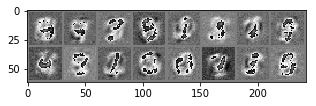

[141/500][400/600][850] Loss_D: -7.354775 Loss_G: -1.152209 Loss_D_real: -8.387590 Loss_D_fake -1.032815


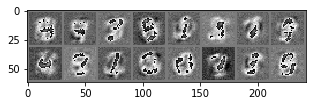

[149/500][600/600][900] Loss_D: -6.955854 Loss_G: -1.122078 Loss_D_real: -7.990472 Loss_D_fake -1.034618


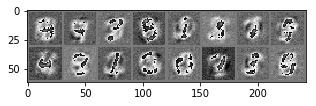

[158/500][200/600][950] Loss_D: -6.451054 Loss_G: -1.149622 Loss_D_real: -7.728720 Loss_D_fake -1.277666


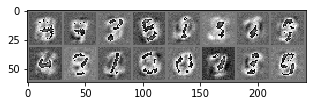

[166/500][400/600][1000] Loss_D: -6.888568 Loss_G: -1.419823 Loss_D_real: -7.989876 Loss_D_fake -1.101308


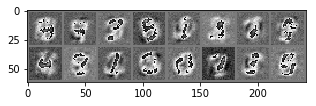

[174/500][600/600][1050] Loss_D: -6.794673 Loss_G: -1.103040 Loss_D_real: -8.028296 Loss_D_fake -1.233623


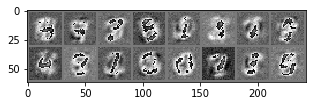

[183/500][200/600][1100] Loss_D: -6.702318 Loss_G: -1.170446 Loss_D_real: -7.993514 Loss_D_fake -1.291196


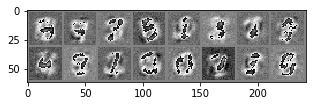

[191/500][400/600][1150] Loss_D: -6.637381 Loss_G: -1.319733 Loss_D_real: -7.955107 Loss_D_fake -1.317726


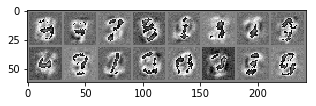

[199/500][600/600][1200] Loss_D: -6.383619 Loss_G: -1.028987 Loss_D_real: -7.557179 Loss_D_fake -1.173560


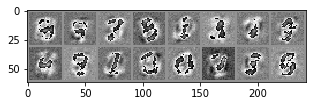

[208/500][200/600][1250] Loss_D: -6.618959 Loss_G: -1.164959 Loss_D_real: -8.041890 Loss_D_fake -1.422931


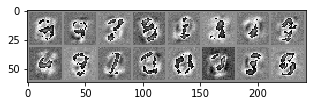

[216/500][400/600][1300] Loss_D: -7.164943 Loss_G: -1.345340 Loss_D_real: -8.593822 Loss_D_fake -1.428879


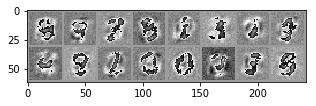

[224/500][600/600][1350] Loss_D: -6.537325 Loss_G: -1.243487 Loss_D_real: -7.585456 Loss_D_fake -1.048131


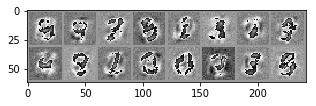

[233/500][200/600][1400] Loss_D: -6.296072 Loss_G: -1.346297 Loss_D_real: -7.548245 Loss_D_fake -1.252173


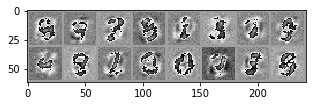

[241/500][400/600][1450] Loss_D: -6.635336 Loss_G: -1.183915 Loss_D_real: -7.979026 Loss_D_fake -1.343690


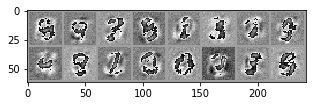

[249/500][600/600][1500] Loss_D: -6.139855 Loss_G: -1.506469 Loss_D_real: -7.379797 Loss_D_fake -1.239941


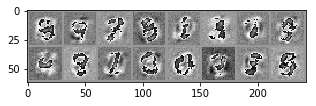

[258/500][200/600][1550] Loss_D: -6.035317 Loss_G: -1.614109 Loss_D_real: -7.460164 Loss_D_fake -1.424846


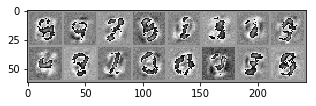

[266/500][400/600][1600] Loss_D: -6.783553 Loss_G: -0.960570 Loss_D_real: -8.156430 Loss_D_fake -1.372878


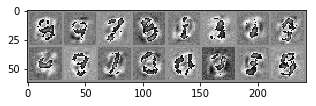

[274/500][600/600][1650] Loss_D: -6.423428 Loss_G: -1.176089 Loss_D_real: -7.453300 Loss_D_fake -1.029873


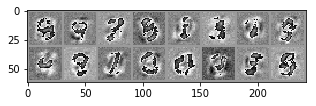

[283/500][200/600][1700] Loss_D: -6.420534 Loss_G: -1.179757 Loss_D_real: -7.494512 Loss_D_fake -1.073978


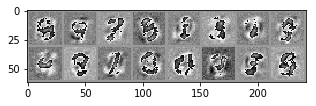

[291/500][400/600][1750] Loss_D: -5.914624 Loss_G: -1.459224 Loss_D_real: -7.010985 Loss_D_fake -1.096361


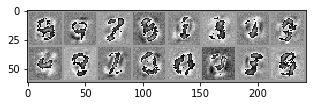

[299/500][600/600][1800] Loss_D: -5.685695 Loss_G: -1.194404 Loss_D_real: -7.138350 Loss_D_fake -1.452656


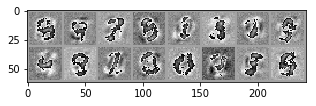

[308/500][200/600][1850] Loss_D: -6.268763 Loss_G: -1.404207 Loss_D_real: -7.620709 Loss_D_fake -1.351946


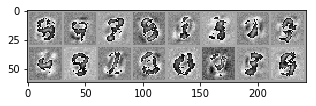

[316/500][400/600][1900] Loss_D: -5.783733 Loss_G: -1.258955 Loss_D_real: -6.991909 Loss_D_fake -1.208175


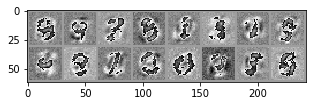

[324/500][600/600][1950] Loss_D: -5.851939 Loss_G: -1.207507 Loss_D_real: -7.107384 Loss_D_fake -1.255444


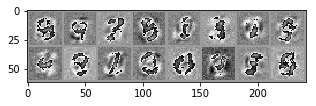

[333/500][200/600][2000] Loss_D: -5.758016 Loss_G: -1.077108 Loss_D_real: -7.436336 Loss_D_fake -1.678321


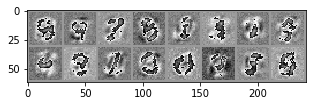

[341/500][400/600][2050] Loss_D: -5.777306 Loss_G: -1.379959 Loss_D_real: -7.166905 Loss_D_fake -1.389600


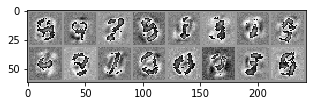

[349/500][600/600][2100] Loss_D: -5.969691 Loss_G: -1.390445 Loss_D_real: -7.180201 Loss_D_fake -1.210509


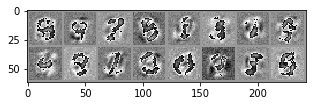

[358/500][200/600][2150] Loss_D: -5.983088 Loss_G: -1.077923 Loss_D_real: -7.239536 Loss_D_fake -1.256447


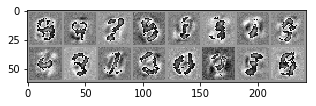

[366/500][400/600][2200] Loss_D: -6.007343 Loss_G: -1.414142 Loss_D_real: -7.057706 Loss_D_fake -1.050363


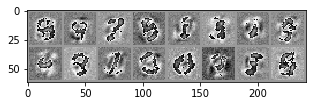

[374/500][600/600][2250] Loss_D: -5.760622 Loss_G: -1.070691 Loss_D_real: -7.015009 Loss_D_fake -1.254387


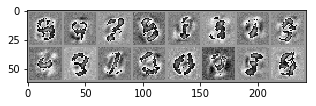

[383/500][200/600][2300] Loss_D: -6.014925 Loss_G: -1.301711 Loss_D_real: -7.202569 Loss_D_fake -1.187645


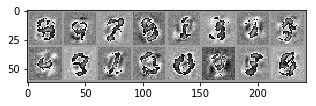

[391/500][400/600][2350] Loss_D: -5.225187 Loss_G: -1.430627 Loss_D_real: -6.512476 Loss_D_fake -1.287289


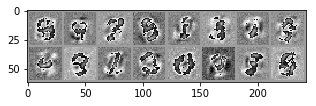

[399/500][600/600][2400] Loss_D: -5.233160 Loss_G: -1.288566 Loss_D_real: -6.578747 Loss_D_fake -1.345586


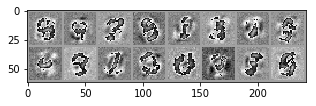

[408/500][200/600][2450] Loss_D: -5.749898 Loss_G: -1.427253 Loss_D_real: -6.846556 Loss_D_fake -1.096657


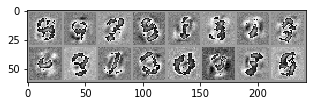

[416/500][400/600][2500] Loss_D: -5.288716 Loss_G: -1.365108 Loss_D_real: -6.408562 Loss_D_fake -1.119845


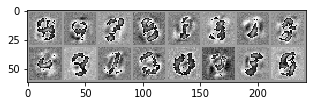

[424/500][600/600][2550] Loss_D: -5.867744 Loss_G: -1.517737 Loss_D_real: -7.101270 Loss_D_fake -1.233526


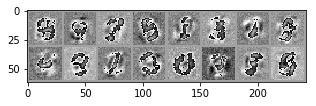

[433/500][200/600][2600] Loss_D: -5.152871 Loss_G: -1.271521 Loss_D_real: -6.360066 Loss_D_fake -1.207195


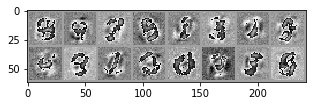

[441/500][400/600][2650] Loss_D: -5.456734 Loss_G: -1.469761 Loss_D_real: -6.571485 Loss_D_fake -1.114751


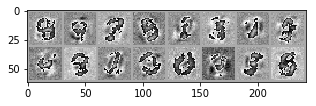

[449/500][600/600][2700] Loss_D: -5.249819 Loss_G: -1.014387 Loss_D_real: -6.745004 Loss_D_fake -1.495185


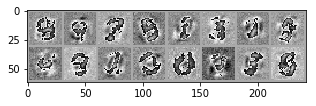

[458/500][200/600][2750] Loss_D: -5.138508 Loss_G: -1.451252 Loss_D_real: -6.566908 Loss_D_fake -1.428399


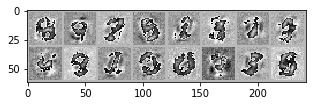

[466/500][400/600][2800] Loss_D: -4.642860 Loss_G: -1.509899 Loss_D_real: -6.138838 Loss_D_fake -1.495978


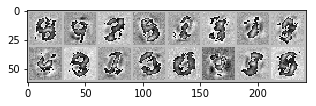

[474/500][600/600][2850] Loss_D: -5.290559 Loss_G: -1.519426 Loss_D_real: -6.517730 Loss_D_fake -1.227171


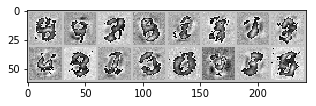

[483/500][200/600][2900] Loss_D: -5.026179 Loss_G: -1.237047 Loss_D_real: -6.581817 Loss_D_fake -1.555638


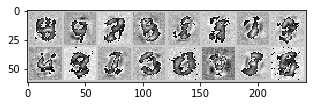

[491/500][400/600][2950] Loss_D: -5.409811 Loss_G: -1.548761 Loss_D_real: -6.409809 Loss_D_fake -0.999998


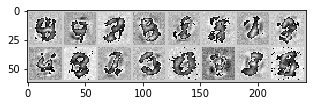

[499/500][600/600][3000] Loss_D: -5.891171 Loss_G: -1.502723 Loss_D_real: -7.096636 Loss_D_fake -1.205465


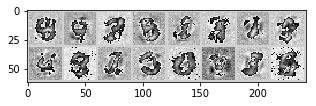

In [44]:
from IPython.core.debugger import Tracer
gen_iterations = 0
for epoch in range(niter):
    #Tracer()()
    data_iter = iter(dataloader)
    i = 0
    while i < len(dataloader):
        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update

        # train the discriminator Diters times
        if gen_iterations < 25 or gen_iterations % 500 == 0:
            Diters = 100
        #else:
        #    Diters = opt.Diters
        j = 0
        while j < Diters and i < len(dataloader):
            j += 1

            # clamp parameters to a cube
            for p in netD.parameters():
                p.data.clamp_(clamp_lower, clamp_upper)

            data = data_iter.next()
            i += 1

            # train with real
            real_cpu, _ = data
            netD.zero_grad()
            batch_size = real_cpu.size(0)

            if torch.cuda.is_available():
                real_cpu = real_cpu.cuda()
            input.resize_as_(real_cpu).copy_(real_cpu)
            inputv = Variable(input)
            errD_real = netD(inputv)
            errD_real.backward(one)

            # train with fake
            noise.resize_(batchSize, nz, 1, 1).normal_(0, 1)
            noisev = Variable(noise, volatile = True) # totally freeze netG
            fake = Variable(netG(noisev).data)
            inputv = fake
            errD_fake = netD(inputv)
            errD_fake.backward(mone)
            errD = errD_real - errD_fake
            optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        for p in netD.parameters():
            p.requires_grad = False # to avoid computation
        netG.zero_grad()
        # in case our last batch was the tail batch of the dataloader,
        # make sure we feed a full batch of noise
        noise.resize_(batchSize, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        errG = netD(fake)
        errG.backward(one)
        optimizerG.step()
        gen_iterations += 1


        if gen_iterations % 50 == 0:
            print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f'
            % (epoch, niter, i, len(dataloader), gen_iterations,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))
            real_cpu = real_cpu.mul(0.5).add(0.5)
            vutils.save_image(real_cpu, '{0}/real_samples.png'.format(experiment))
            fake = netG(Variable(fixed_noise, volatile=True))
            fake = fake.mul(0.5).add(0.5)
            vutils.save_image(fake.data, '{0}/fake_samples.png'.format(experiment))
            #print('show')
            if torch.cuda.is_available():
                dd = utils.make_grid(fake.cpu().data[:16])
            else:
                dd = utils.make_grid(fake.data[:16])
            dd = dd - dd.min()
            imshow(dd)
            
    # do checkpointing
    #torch.save(netG.state_dict(), '{0}/WGANnetG_epoch_{1}.pth'.format(experiment, epoch))
    #torch.save(netD.state_dict(), '{0}/WGANnetD_epoch_{1}.pth'.format(experiment, epoch))
    torch.save(netG.state_dict(), '{0}/WGANnetG.pth'.format(experiment))
    torch.save(netD.state_dict(), '{0}/WGANnetD.pth'.format(experiment))